## 3) Magnetohidrodinámica

> Haciendo uso del solver MHDB,
resuelva numéricamente las ecuaciones MHD
con un campo guía $B_0 = B_0 ẑ$
desde $t = 0$ hasta $t = 20$
usando $dt = 4 × 10^{−3}$
con $128 × 128 × 64$ puntos espaciales en un dominio con tamaño 2π × 2π × 2π.
Imponga un campo guía $B_0 = 2$,
y utilice una viscosidad cinemática y difusividad magnética $ν = η = 3.5 × 10^{−3}$.
Utilice condiciones iniciales aleatorias para el campo de velocidad y magnético
con amplitud igual a $1$
entre `kdn = 1` y `kup = 10`,
con una correlación cruzada $K$ mayor a $∼0.3$,
y sin fuerzas externas.
En particular,
deje decaer libremente al sistema
(si a $t = 0$ $K$ es menor que $∼0.3$,
cambie el valor de la semilla *seed* para el generador de números al azar en el archivo `"parameter.inp"`).

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common import Output
from ghost_xarray import open_dataset

output = Output(
    "problema3/output",
    dt=4e-3 * 125,
    balance=["time", "<v^2>+<b^2>", "<omega^2>", "<j^2>"],
    energy=["time", "<v^2>", "<b^2>"],
    helicity=["time", "kinetic helicity", "magnetic helicity"],
    cross=["time", "<v.b>", "<a^2>"],
    kspectrum=["k", "Ev"],
    mspectrum=["k", "Eb"],
)

> a) Grafique la energía total y la helicidad cruzada en función del tiempo.
¿Decaen con la misma tasa?

In [2]:
data = output.load_global_output("balance", "cross")
data.head(2)

,<v^2>+<b^2>,<omega^2>,<j^2>,<v.b>,<a^2>
time,,,,,
0.00,2.210863,9.946115,9.243430,0.710863,0.695657
0.04,2.205510,9.831027,9.255789,0.709432,0.699903


Para ver la tasa de decaimiento,
vemos la derivada (a menos de un factor $\Delta t$):

<AxesSubplot: xlabel='time'>

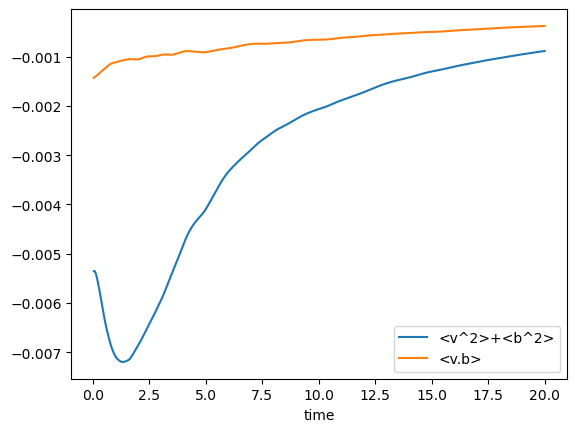

In [3]:
data[["<v^2>+<b^2>", "<v.b>"]].diff().plot()

La energía $\langle v^2 \rangle + \langle b^2 \rangle$
decae más rápido que
la correlación cruzada $\langle v \cdot b \rangle$.

> b) Grafique la energía cinética y magnética en función del tiempo.

<AxesSubplot: xlabel='time'>

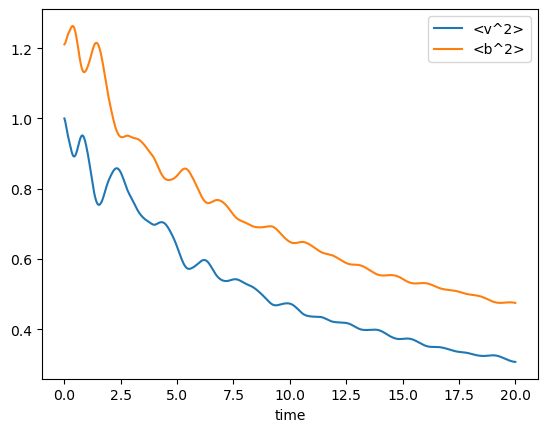

In [4]:
output.load_global_output("energy").plot()

> c) Grafique el producto
>
> $$\frac{u · b}{(⟨u^2 ⟩⟨b^2 ⟩)^{1/2}}$$
>
> ¿A qué valor evoluciona? ¿Por qué?

In [5]:
data = output.load_global_output("energy", "cross")
data.head(2)

,<v^2>,<b^2>,<v.b>,<a^2>
time,,,,
0.00,1.00000,1.210863,0.710863,0.695657
0.04,0.99089,1.214620,0.709432,0.699903


La correlación entre $v$ y $b$ aumenta a medida que pasa el tiempo,
casi llegando a $1$ para el fin de la simulación.
Es decir,
los campos se alinean a medida que evolucionan.

<AxesSubplot: xlabel='time'>

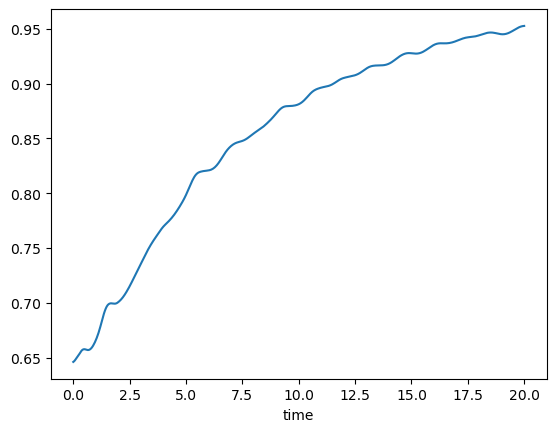

In [6]:
K = data["<v.b>"] / (data["<v^2>"] * data["<b^2>"])**0.5
K.plot()

> d) Grafique los espectros de la energía cinética y magnética.
¿Qué pendientes observa en dichos espectros?

In [7]:
data = output.load_global_output("balance")
data.head(2)

,<v^2>+<b^2>,<omega^2>,<j^2>
time,,,
0.00,2.210863,9.946115,9.243430
0.04,2.205510,9.831027,9.255789


$$ \frac{dE}{dt} = ε − 2νZ - 2\eta \int \langle j^2 \rangle $$

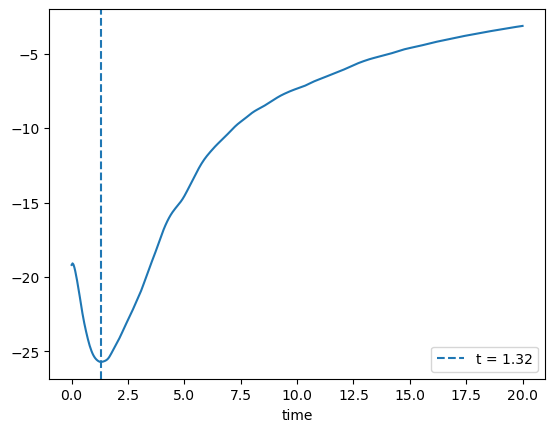

In [8]:
dEdT = -(data["<j^2>"] + data["<omega^2>"])
t_max = dEdT.idxmin()

dEdT.plot()
plt.axvline(t_max, linestyle="--", label=f"t = {t_max:.2f}")
plt.legend()

In [7]:
data = output.load_output("kspectrum", "mspectrum")
data

<xarray.Dataset>
Dimensions:  (time: 41, k: 65)
Coordinates:
  * time     (time) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 18.0 18.5 19.0 19.5 20.0
  * k        (k) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 61.0 62.0 63.0 64.0 65.0
Data variables:
    Ev       (time, k) float64 0.2284 0.1191 0.04924 0.03421 ... 0.0 0.0 0.0 0.0
    Eb       (time, k) float64 0.3878 0.08431 0.04173 0.02765 ... 0.0 0.0 0.0

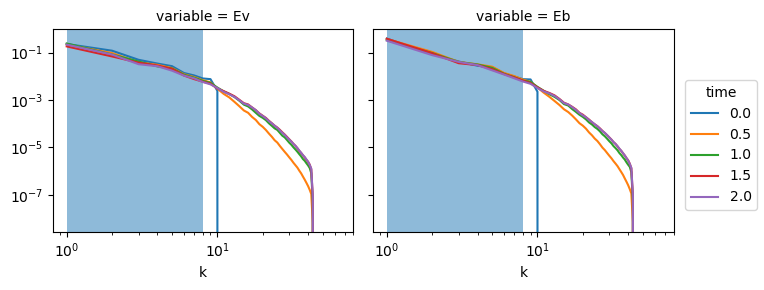

In [8]:
ax = data.isel(time=slice(0, 5)).to_array().plot.line(col="variable", x="k", yscale="log", xscale="log")
for ax in ax.axes.flat:
    ax.axvspan(1, 8, alpha=0.5)

In [10]:
def fit_power_law(x):
    p, cov = np.polyfit(np.log(x.k), np.log(x), 1, cov=True)
    return pd.Series({"pendiente": p[0], "error": cov[0,0]**0.5})

data.isel(time=2).sel(k=slice(0, 8)).map(fit_power_law).to_dataframe()

,Ev,Eb
dim_0,,
pendiente,-1.718484,-1.835129
error,0.070051,0.076639


In [14]:
data.isel(time=2).sel(k=slice(15, 35)).map(fit_power_law).to_dataframe()

,Ev,Eb
dim_0,,
pendiente,-5.744405,-5.654859
error,0.114242,0.119550
